https://www.kaggle.com/code/blackadder97/militaryaircraftdetection-with-yolov5

In [2]:
import os
import shutil
import numpy as np
import pandas as pd

from tqdm import tqdm
from pathlib import Path

In [3]:
np.random.seed(42)

In [4]:
!mkdir ../choicedatasets

In [10]:
data_dir = '../data/dataset'
!ls {data_dir}

annotated_samples crop              dataset


In [11]:
# convert str to Path
data_dir = Path(data_dir)

# read image dir
image_paths = []
annotation_paths = []
# collect image paths and annotations
for file_name in sorted(os.listdir(data_dir / 'dataset')):
    file_name = Path(file_name)
    if file_name.suffix == '.jpg':
        image_paths.append(data_dir / 'dataset' / file_name)
    if file_name.suffix == '.csv':
        annotation_paths.append(data_dir / 'dataset' / file_name)

In [12]:
# collect class names
class_names = sorted(os.listdir(data_dir / 'crop'))
# create class2idx map
class2idx = {class_name: i for i, class_name in enumerate(class_names)}

In [13]:
class2idx

{'.DS_Store': 0,
 'A10': 1,
 'A400M': 2,
 'AG600': 3,
 'AV8B': 4,
 'B1': 5,
 'B2': 6,
 'B52': 7,
 'Be200': 8,
 'C130': 9,
 'C17': 10,
 'C2': 11,
 'C5': 12,
 'E2': 13,
 'E7': 14,
 'EF2000': 15,
 'F117': 16,
 'F14': 17,
 'F15': 18,
 'F16': 19,
 'F18': 20,
 'F22': 21,
 'F35': 22,
 'F4': 23,
 'J10': 24,
 'J20': 25,
 'JAS39': 26,
 'KC135': 27,
 'MQ9': 28,
 'Mig31': 29,
 'Mirage2000': 30,
 'P3': 31,
 'RQ4': 32,
 'Rafale': 33,
 'SR71': 34,
 'Su25': 35,
 'Su34': 36,
 'Su57': 37,
 'Tornado': 38,
 'Tu160': 39,
 'Tu95': 40,
 'U2': 41,
 'US2': 42,
 'V22': 43,
 'Vulcan': 44,
 'XB70': 45,
 'YF23': 46}

In [14]:
def convert_bboxes_to_yolo_format(df: pd.DataFrame, class2idx: dict):
    df['class'] = df['class'].apply(lambda x: class2idx[x]).values
    df['xmin'] = (df['xmin'] / df['width']).values
    df['ymin'] = (df['ymin'] / df['height']).values
    df['xmax'] = (df['xmax'] / df['width']).values
    df['ymax'] = (df['ymax'] / df['height']).values
    df['xc']   = (df['xmin'] + df['xmax']) / 2
    df['yc']   = (df['ymin'] + df['ymax']) / 2
    df['w']    = (df['xmax'] - df['xmin'])
    df['h']    = (df['ymax'] - df['ymin'])
    df.drop(
        ['filename', 'width', 'height', 'xmin', 'xmax', 'ymin', 'ymax'], 
        axis=1, 
        inplace=True
    )
    return df 

In [15]:
image_dir = data_dir / 'images'
label_dir = data_dir / 'labels'
os.makedirs(image_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

In [16]:
# create .txt annotations
for annotation_path in tqdm(annotation_paths):
    # get image_id
    image_id = annotation_path.parts[-1].split('.')[0]
    annotation_df = pd.read_csv(annotation_path)
    # transform to yolo format
    annotation_df = convert_bboxes_to_yolo_format(annotation_df, class2idx)
    # save to .txt resulting df
    with open(Path(label_dir) / f'{image_id}.txt', 'w') as f:
        f.write(annotation_df.to_string(header=False, index=False))

100%|██████████| 13189/13189 [00:32<00:00, 412.06it/s]


In [17]:
for image_path in image_paths:
    shutil.move(str(image_path), image_dir)

In [ ]:
shutil.rmtree(data_dir / 'dataset')
shutil.rmtree(data_dir / 'crop')
shutil.rmtree(data_dir / 'annotated')

In [19]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)

from PIL import Image
from matplotlib.patches import Rectangle

In [20]:
# generate colors
cmap = plt.get_cmap('rainbow', len(class2idx))
# generate random ids to visualize
sample_ids = np.random.randint(0, len(os.listdir(image_dir)), 4)
# invert class2idx -> idx2class
idx2class = {class_id: class_name for class_name, class_id in class2idx.items()}

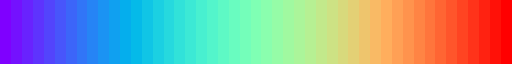

In [21]:
cmap

In [22]:
image_paths = [Path(image_dir) / image_path for image_path in sorted(os.listdir(image_dir))]
label_paths = [Path(label_dir) / label_path for label_path in sorted(os.listdir(label_dir))]

In [23]:
image = np.array(Image.open(image_paths[sample_ids[0]]))
bboxes = np.loadtxt(label_paths[sample_ids[0]], ndmin=2)

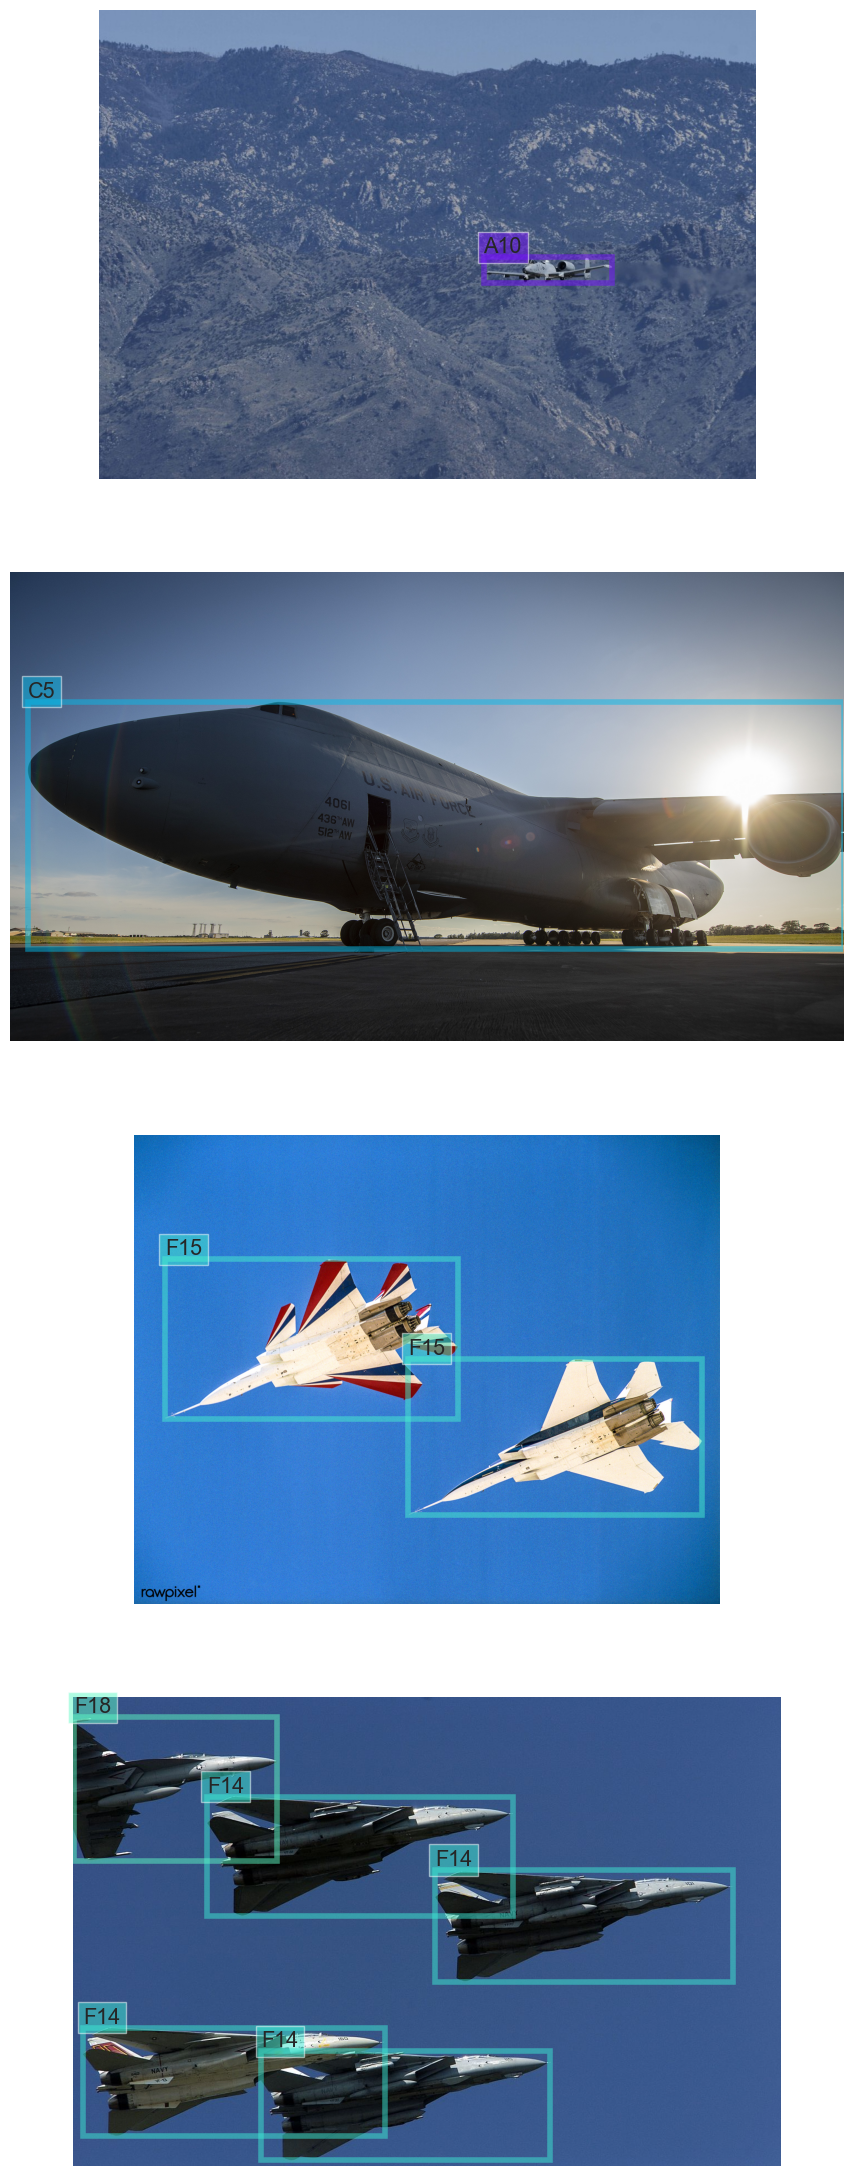

In [24]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 4 * 7))

for i, sample_id in enumerate(sample_ids):
    # load image and bboxes
    image = np.array(Image.open(image_paths[sample_id]))
    bboxes = np.loadtxt(label_paths[sample_id], ndmin=2)
    # get image shape
    image_h, image_w = image.shape[:2]

    for bbox in bboxes:
        class_id, xc, yc, w, h = bbox
        # rescale to image size
        xc, yc, w, h = image_w * xc, image_h * yc, image_w * w, image_h * h
        xmin, ymin = xc - w / 2, yc - h / 2
        rect = Rectangle(
            (xmin, ymin), 
            w, h, 
            linewidth=4, 
            edgecolor=cmap(int(class_id)), 
            facecolor='none',
            alpha=0.5
        )
        ax[i].add_patch(rect)
        ax[i].text(
            xmin, ymin, 
            idx2class[int(class_id)], 
            ha='left', va='bottom',
            bbox={'facecolor': cmap(int(class_id)), 'alpha': 0.5}
        )

    ax[i].imshow(image)
    ax[i].axis('off');

In [25]:
from collections import Counter
from sklearn.model_selection import train_test_split

In [26]:
image_paths = [f'images/{image_path}' for image_path in sorted(os.listdir(image_dir))]

In [27]:
train_size = 0.8

In [28]:
train_image_paths, val_image_paths = train_test_split(
    image_paths, train_size=train_size, random_state=42, shuffle=True)

In [29]:
# make train split
with open(data_dir / 'train_split.txt', 'w') as f:
    f.writelines(f'./{image_path}\n' for image_path in train_image_paths)

# make val split
with open(data_dir / 'val_split.txt', 'w') as f:
    f.writelines(f'./{image_path}\n' for image_path in val_image_paths)

In [30]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
# set fonttype
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42

%matplotlib inline

In [31]:
class_counter = {'train': Counter(), 'val': Counter()}
class_freqs = {}

with open(data_dir / 'train_split.txt', 'r') as f:
    for line in f:
        image_id = line.split('/')[-1].split('.')[0]
        df = np.loadtxt(label_dir / f'{image_id}.txt',ndmin=2)
        class_counter['train'].update(df[:, 0].astype(int))
# get class freqs
total = sum(class_counter['train'].values())
class_freqs['train'] = {k: v / total for k, v in class_counter['train'].items()}
        
with open(data_dir / 'val_split.txt', 'r') as f:
    for line in f:
        image_id = line.split('/')[-1].split('.')[0]
        df = np.loadtxt(label_dir / f'{image_id}.txt',ndmin=2)
        class_counter['val'].update(df[:, 0].astype(int))
# get class freqs
total = sum(class_counter['val'].values())
class_freqs['val'] = {k: v / total for k, v in class_counter['val'].items()}

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(range(20), [class_freqs['train'][i] for i in range(20)], color='navy', label='train');
# ax.plot(range(46), [class_freqs['val'][i] for i in range(46)], color='tomato', label='val');
ax.legend();
ax.set_xlabel('Class ID');
ax.set_ylabel('Class Frequency');

In [ ]:
data_yaml = '''
path: ../datasets/militaryaircraftdetectiondataset  # dataset root dir
train: train_split.txt  # train images (relative to 'path') 
val: val_split.txt  # val images (relative to 'path') 
test:  # test images (optional)

# Classes
names:
'A10': 1,
 'A400M': 2,
 'AG600': 3,
 'AV8B': 4,
 'B1': 5,
 'B2': 6,
 'B52': 7,
 'Be200': 8,
 'C130': 9,
 'C17': 10,
 'C2': 11,
 'C5': 12,
 'E2': 13,
 'E7': 14,
 'EF2000': 15,
 'F117': 16,
 'F14': 17,
 'F15': 18,
 'F16': 19,
 'F18': 20,
 'F22': 21,
 'F35': 22,
 'F4': 23,
 'J10': 24,
 'J20': 25,
 'JAS39': 26,
 'KC135': 27,
 'MQ9': 28,
 'Mig31': 29,
 'Mirage2000': 30,
 'P3': 31,
 'RQ4': 32,
 'Rafale': 33,
 'SR71': 34,
 'Su25': 35,
 'Su34': 36,
 'Su57': 37,
 'Tornado': 38,
 'Tu160': 39,
 'Tu95': 40,
 'U2': 41,
 'US2': 42,
 'V22': 43,
 'Vulcan': 44,
 'XB70': 45,
 'YF23': 46}
'''